In [91]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score

In [68]:
time_series = pd.read_csv("training.csv")
time_series["Date"] = pd.to_datetime(time_series["Date"])
time_series = time_series.set_index('Date')
test_series = pd.read_csv("testing.csv")
test_series["Date"] = pd.to_datetime(test_series["Date"])
test_series = test_series.set_index('Date')

<function matplotlib.pyplot.show(close=None, block=None)>

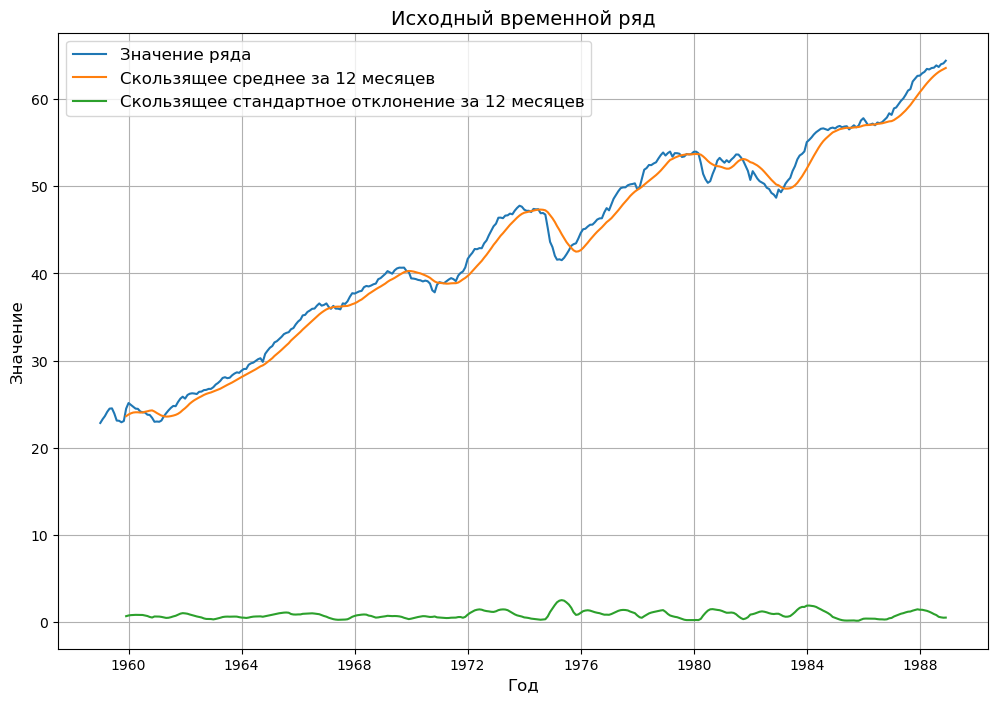

In [57]:
plt.figure(figsize = (12, 8))

plt.plot(time_series, label = "Значение ряда")
plt.plot(time_series.rolling(window = 12).mean(), label = "Скользящее среднее за 12 месяцев")
plt.plot(time_series.rolling(window = 12).std(), label = "Скользящее стандартное отклонение за 12 месяцев")
plt.legend(title = '', loc = 'upper left', fontsize = 12)

plt.xlabel("Год", fontsize = 12)
plt.ylabel("Значение", fontsize = 12)
plt.title("Исходный временной ряд", fontsize = 14)
plt.grid()

plt.show

In [58]:
test = adfuller(time_series["Value"])
print("ADF Statistic: %.3f" % test[0])
print("p-value: %.3f" % test[1])
print("Critical values:")
for key, value in test[4].items():
    print('%s: %.3f' % (key, value))
if test[0] > test[4]["5%"]:
  print("есть единичные корни, ряд не стационарен")
else:
  print("нет единичных корней, ряд стационарен")

ADF Statistic: -0.253
p-value: 0.932
Critical values:
1%: -3.449
5%: -2.870
10%: -2.571
есть единичные корни, ряд не стационарен


***MULTIPLICATIVE:***

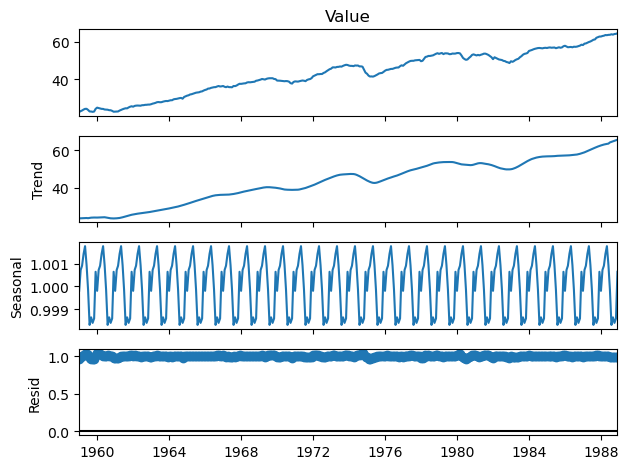

In [59]:
decompose = seasonal_decompose(time_series["Value"], model = 'multiplicative', extrapolate_trend = 'freq')
decompose.plot()
plt.show()

In [61]:
print("1 - trend; 2 - seasonal; 3 - residual:")
test = adfuller(decompose.trend)
if test[0] > test[4]["5%"]:
  print("1) есть единичные корни, ряд не стационарен")
else:
  print("1) нет единичных корней, ряд стационарен")

test = adfuller(decompose.seasonal)
if test[0] > test[4]["5%"]:
  print("2) есть единичные корни, ряд не стационарен")
else:
  print("2) нет единичных корней, ряд стационарен")

test = adfuller(decompose.resid)
if test[0] > test[4]["5%"]:
  print("3) есть единичные корни, ряд не стационарен")
else:
  print("3) нет единичных корней, ряд стационарен")


1 - trend; 2 - seasonal; 3 - residual:
1) есть единичные корни, ряд не стационарен
2) нет единичных корней, ряд стационарен
3) нет единичных корней, ряд стационарен


***ADDITIVE:***

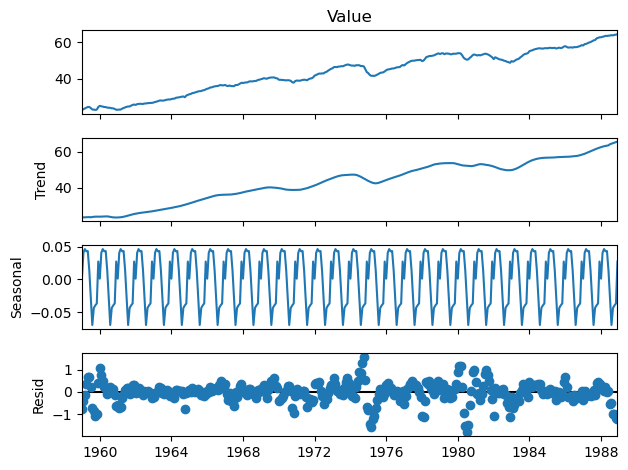

In [62]:
decompose = seasonal_decompose(time_series["Value"], model='additive', extrapolate_trend='freq')
decompose.plot()
plt.show()

In [63]:
print("1 - trend; 2 - seasonal; 3 - residual:")
test = adfuller(decompose.trend)
if test[0] > test[4]["5%"]:
  print("1) есть единичные корни, ряд не стационарен")
else:
  print("1) нет единичных корней, ряд стационарен")

test = adfuller(decompose.seasonal)
if test[0] > test[4]["5%"]:
  print("2) есть единичные корни, ряд не стационарен")
else:
  print("2) нет единичных корней, ряд стационарен")

test = adfuller(decompose.resid)
if test[0] > test[4]["5%"]:
  print("3) есть единичные корни, ряд не стационарен")
else:
  print("3) нет единичных корней, ряд стационарен")

1 - trend; 2 - seasonal; 3 - residual:
1) есть единичные корни, ряд не стационарен
2) нет единичных корней, ряд стационарен
3) нет единичных корней, ряд стационарен


***ПРОВЕРКА НА ИНТЕГРИРУЕМОСТЬ ПОРЯДКА К:***




In [65]:
k = 1
while 1:
    b = time_series["Value"].diff(periods = k).dropna()
    test = adfuller(b)
    print ('ADF Statistic: ', test[0]) 
    print ('p-value: ', test[1])
    print ('Critical values: ', test[4])
    if test[0] <= test[4]["5%"]:
        break
    k += 1
print("К =", k)


ADF Statistic:  -7.367311495211983
p-value:  9.164149561098213e-11
Critical values:  {'1%': -3.4489583388155194, '5%': -2.869739378430086, '10%': -2.5711381780459}
К = 1


Для моделирования будем использовать модель ARIMA, построенную для ряда первых разностей.
Итак, чтобы построить модель нам нужно знать ее порядок, состоящий из 2-х параметров:
p — порядок компоненты AR
d — порядок интегрированного ряда
q — порядок компонетны MA


Параметр d есть и он равен 16, осталось определить p и q. Для их определения нам надо изучить автокорреляционную(ACF) и частично автокорреляционную(PACF) функции для ряда первых разностей.
ACF поможет нам определить q, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов, сильно отличных от 0 в модели MA
PACF поможет нам определить p, т. к. по ее коррелограмме можно определить максимальный номер коэффициента, сильно отличный от 0 в модели AR.

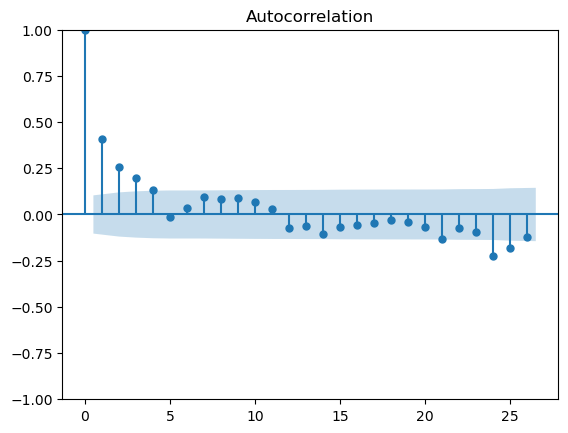

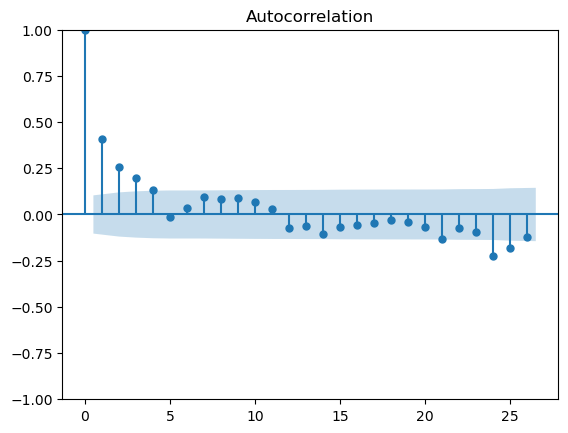

In [66]:
plot_acf(time_series.diff().dropna())

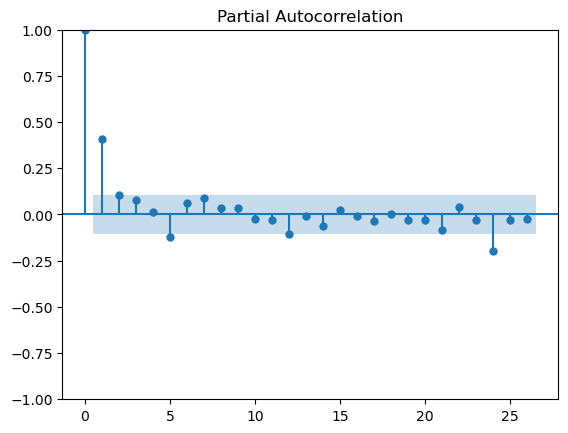

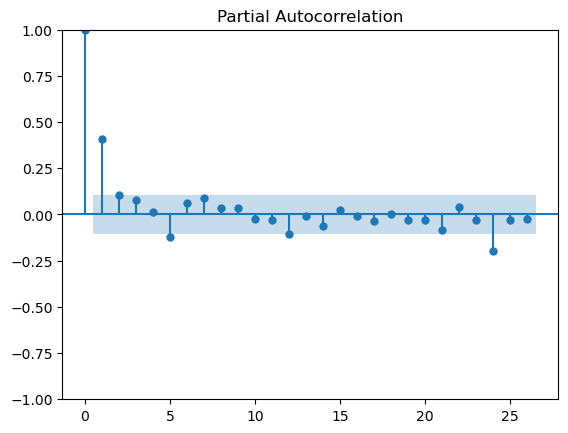

In [67]:
plot_pacf(time_series["Value"].diff().dropna())

После изучения коррелограммы ACF можно сделать вывод, что p = 2, т.к. на ней только 1 лаг сильно отличнен от нуля. По коррелограмме PACF можно увидеть, что q = 2

Итак, имеем:
p=2
d=1
q=2

In [98]:
model1 = ARIMA(time_series, order = (2, 1, 2), trend = "t").fit()
model2 = ARIMA(time_series, order = (1, 1, 1)).fit()
model3 = ARIMA(time_series, order = (4, 1, 4), trend = "t").fit()

pred1 = model1.predict(start = "1989-01-01", end = "1993-12-01")
pred2 = model2.predict(start = "1989-01-01", end = "1993-12-01")
pred3 = model3.predict(start = "1989-01-01", end = "1993-12-01")

/Users/marko/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/marko/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/marko/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/marko/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/marko/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provid

In [36]:
print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  360
Model:                ARIMA(2, 16, 2)   Log Likelihood                   0.000
Date:                Thu, 30 Nov 2023   AIC                             10.000
Time:                        10:11:15   BIC                             29.203
Sample:                    01-01-1959   HQIC                            17.648
                         - 12-01-1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1      -3.673e-05         -0        inf      0.000   -3.67e-05   -3.67e-05
ar.L2          1.0000         -0       -inf      0.000       1.000       1.000
ma.L1         -1.9998         -0        inf      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/mlemodel.py:3015: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1363: RuntimeWarning: invalid value encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:691: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


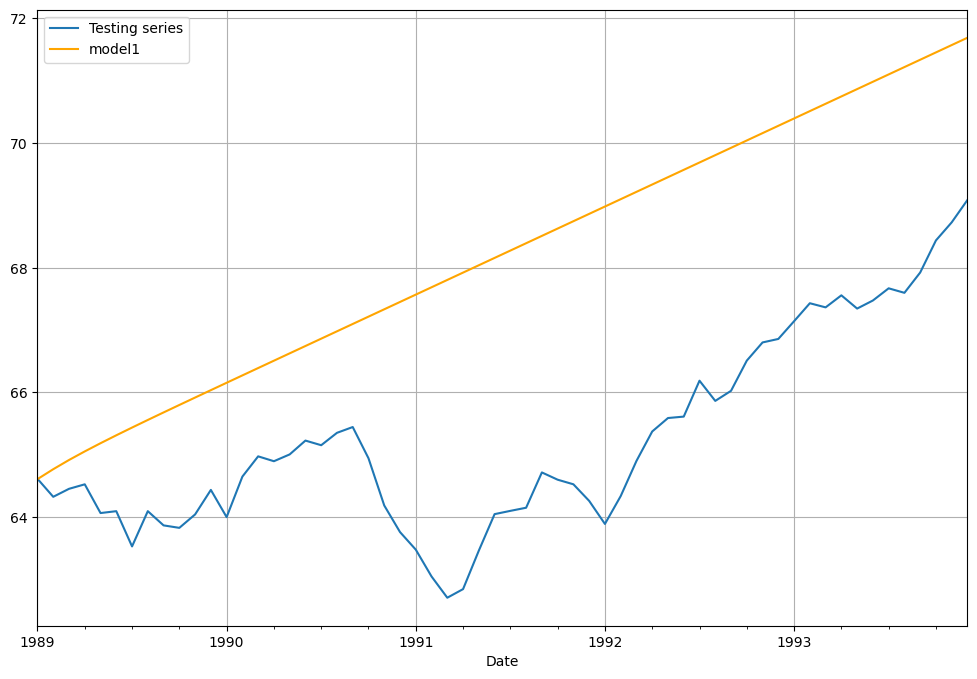

In [88]:
plt.figure(figsize = (12, 8))
test_series.Value.plot(label='Testing series')
pred1.plot(color = 'orange', label = "model1")
plt.grid()
plt.legend(loc = 'upper left')
plt.show()

In [94]:
print('AIC model1: %1.3f' % model1.aic)
r2_1 = r2_score(test_series, pred1)
print('r2 score: %1.3f' % r2_1)

AIC model1: 252.506
r2 score: -3.317


In [99]:
print(model2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  360
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -124.821
Date:                Mon, 04 Dec 2023   AIC                            255.641
Time:                        14:00:23   BIC                            267.291
Sample:                    01-01-1959   HQIC                           260.274
                         - 12-01-1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7401      0.065     11.465      0.000       0.614       0.867
ma.L1         -0.3684      0.080     -4.599      0.000      -0.525      -0.211
sigma2         0.1173      0.006     20.413      0.0

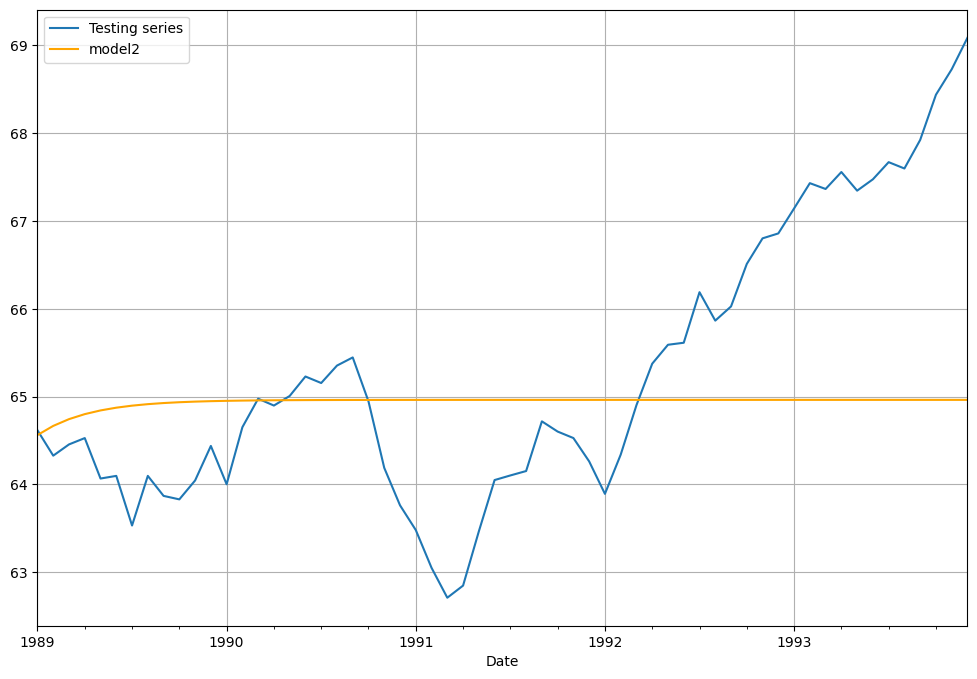

In [103]:
plt.figure(figsize = (12, 8))
test_series.Value.plot(label='Testing series')
pred2.plot(color = 'orange', label = "model2")
plt.grid()
plt.legend(loc = 'upper left')
plt.show()

In [101]:
print('AIC model2: %1.3f' % model2.aic)
r2_2 = r2_score(test_series, pred2)
print('r2 score: %1.3f' % r2_2)

AIC model2: 255.641
r2 score: -0.024


In [102]:
print(model3.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  360
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -116.081
Date:                Mon, 04 Dec 2023   AIC                            252.161
Time:                        14:00:57   BIC                            290.994
Sample:                    01-01-1959   HQIC                           267.604
                         - 12-01-1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1170      0.037      3.138      0.002       0.044       0.190
ar.L1         -0.0915      0.361     -0.253      0.800      -0.799       0.616
ar.L2         -0.2025      0.321     -0.631      0.5

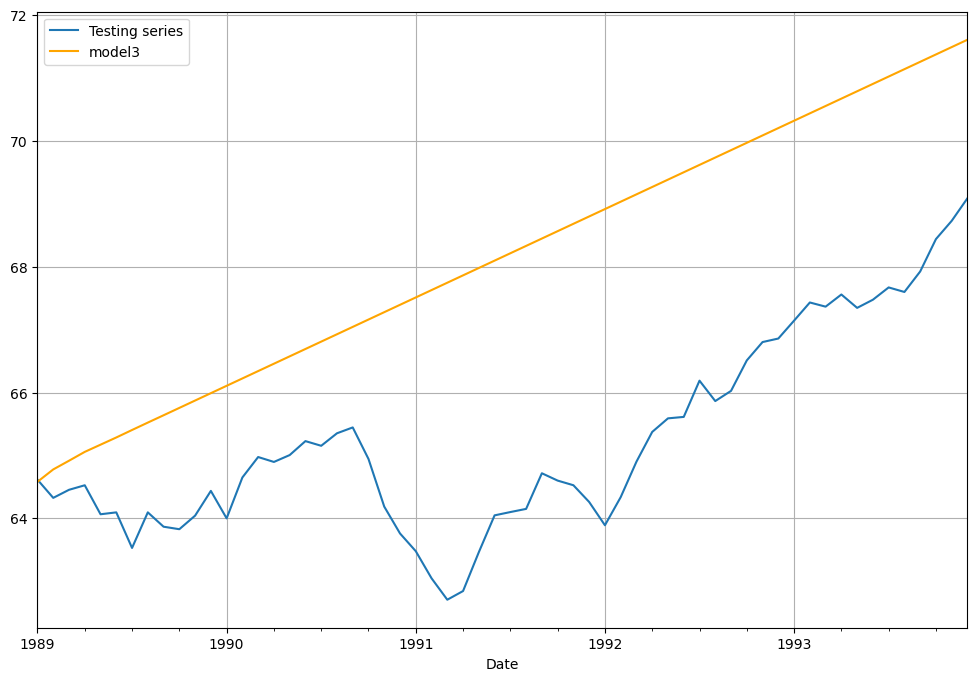

In [104]:
plt.figure(figsize = (12, 8))
test_series.Value.plot(label='Testing series')
pred3.plot(color = 'orange', label = "model3")
plt.grid()
plt.legend(loc = 'upper left')
plt.show()

In [106]:
print('AIC model3: %1.3f' % model3.aic)
r2_3 = r2_score(test_series, pred3)
print('r2 score: %1.3f' % r2_3)

AIC model3: 252.161
r2 score: -3.161
